<a href="https://colab.research.google.com/github/comaraDOTcom/ml-applications/blob/main/Etivity2/ET5003_Etivity2_CONOROMARA_20151845.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [ ]:
#@title Current Date
Today = '2021-08-22' #@param {type:"date"}


In [654]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20151845" #@param {type:"string"}
Student_full_name = "Conor O'Mara" #@param {type:"string"}
#@markdown ---

In [655]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = Final #@param ["Draft", "Final"] {type:"raw"}
Submission = True #@param {type:"boolean"}

NameError: ignored

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [623]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")


# plot settings

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100
sns.set_theme(context='notebook', style='ticks', palette='Accent', font='sans-serif', font_scale=1, color_codes=True, rc=None)

In [624]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D


# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [626]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET
<a name="dataset"></a>

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

### Google drive file paths and IO work.

In [627]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [628]:
path = '/content/drive/My Drive/Masters/ET5003_Enrique/etivity2/house_data/'

In [629]:
train_data = 'house_train.csv'
test_data = 'house_test.csv'
true_price = 'true_price.csv'

In [630]:
df_train = pd.read_csv(path+train_data)
df_test = pd.read_csv(path+test_data)
df_target = pd.read_csv(path + true_price)

### Train dataset

In [632]:
# show first data frame rows 
df_train.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LO...,prod,NaN,None,53.418216,-6.149329,18.0,NaN,new_development_parent,NaN,NaN
1,999327,Lucan,NaN,NaN,NaN,Dublin,**Last 2 remaining houses for sale ***\n\nOn v...,prod,NaN,None,53.364917,-6.454935,3.0,NaN,new_development_parent,NaN,NaN
2,999559,Rathfarnham,NaN,NaN,NaN,Dublin,Final 4 &amp; 5 Bedroom Homes for Sale\n\nOn V...,prod,NaN,None,53.273447,-6.313821,3.0,NaN,new_development_parent,NaN,NaN
3,9102986,Balbriggan,NaN,NaN,NaN,Dublin,"Glenveagh Taylor Hill, Balbriggan\n\r\n*Ideal ...",prod,NaN,None,53.608167,-6.210914,30.0,NaN,new_development_parent,NaN,NaN
4,9106028,Foxrock,NaN,NaN,NaN,Dublin,*New phase launching this weekend Sat &amp; Su...,prod,NaN,None,53.262531,-6.181527,8.0,NaN,new_development_parent,NaN,NaN


In [633]:
# Generate descriptive statistics
df_train.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,price,surface
count,2.982000e+03,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2.892000e+03,2431.000000
mean,1.224065e+07,1.998635,2.979188,53.355991,-6.257175,7.440678,5.323536e+05,318.851787
std,5.793037e+05,1.291875,1.468408,0.086748,0.141906,8.937081,5.678148e+05,4389.423136
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,0.000000,1.999500e+04,3.400000
25%,1.226813e+07,1.000000,2.000000,53.298929,-6.314064,2.000000,2.800000e+05,74.100000
50%,1.237758e+07,2.000000,3.000000,53.345497,-6.252254,3.000000,3.800000e+05,100.000000
75%,1.240294e+07,3.000000,4.000000,53.388845,-6.196049,8.000000,5.750000e+05,142.000000
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,36.000000,9.995000e+06,182108.539008


In [ ]:
def show_nulls(df):
  nulls = pd.DataFrame(df.isna().sum())
  nulls.rename(columns = {0:'Number of Nulls'}, inplace = True) 
  nulls['% of Nulls'] = nulls['Number of Nulls']/df.shape[0]*100
  cols_with_nulls = nulls[nulls['Number of Nulls'] > 0].T.columns.tolist()
  return nulls

In [ ]:
show_nulls(df_train_subset)

In [634]:
features = ['ad_id', 'bathrooms', 'beds', 'latitude', 'longitude', 'surface', 'price']

In [635]:
df_train_subset = df_train[features]
del features[-1]

In [636]:
# drop null price rows (drops 70 rows)
df_train_subset = df_train_subset[~df_train_subset['price'].isna()]

In [638]:
df_train_subset.shape

(2892, 7)

In [639]:
for i in features:
  df_train_subset[i].fillna(df_train_subset[i].median(), inplace=True)

In [640]:
# double check no nulls left
show_nulls(df_train_subset)

,Number of Nulls,% of Nulls
ad_id,0,0.0
bathrooms,0,0.0
beds,0,0.0
latitude,0,0.0
longitude,0,0.0
surface,0,0.0
price,0,0.0


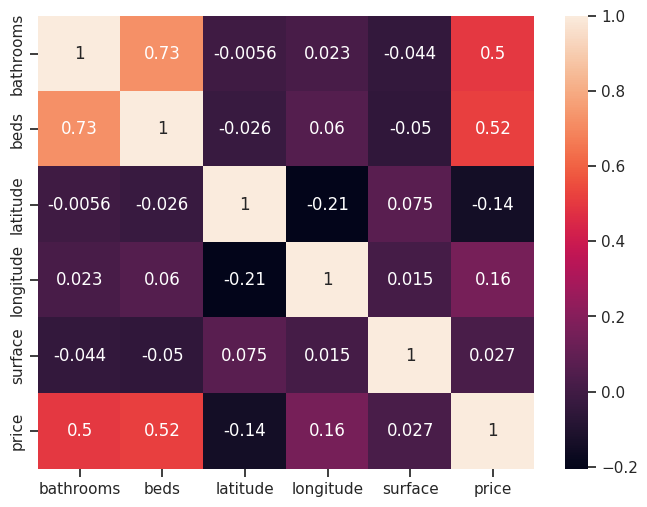

In [649]:
sns.heatmap(df_train_subset[['bathrooms', 'beds', 'latitude', 'longitude', 'surface', 'price']].corr(), annot = True)
plt.show()

<a name="outliers"></a>
### Removing outliers

In [ ]:
#Look at outliers in long and latitude data
def plot_distribtion(df, feature):
    """
    Function plots the histogram and boxplot distribution of the feature side by side.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f'{feature}')
    sns.histplot(ax=ax1, data=df, x=feature, kde=True)
    sns.boxplot(ax=ax2,data=df,  y=feature, palette="Set2")
    plt.show()

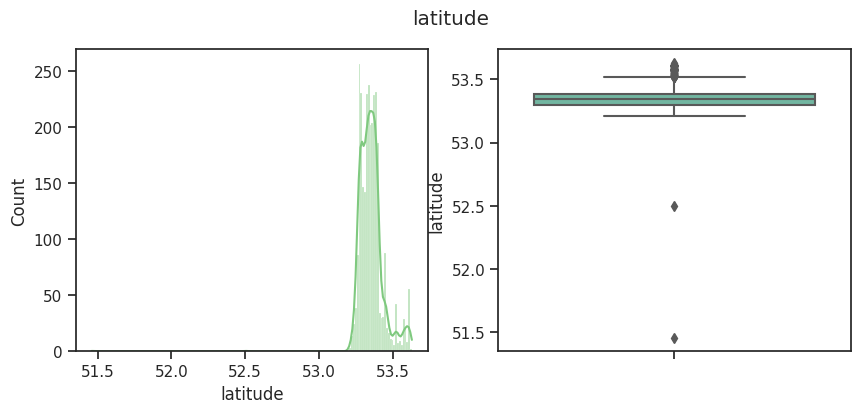

In [ ]:
# lots of outliers exist in the longitudinal data
plot_distribtion(df_train_subset, 'latitude')

In [ ]:
from matplotlib.cbook import boxplot_stats

outliers = [y for stat in boxplot_stats(df_train_subset['latitude']) for y in stat['fliers']]

In [ ]:
#drop rows that contain any value outliers
df_train_subset = df_train_subset[df_train_subset.latitude.isin(outliers) == False]

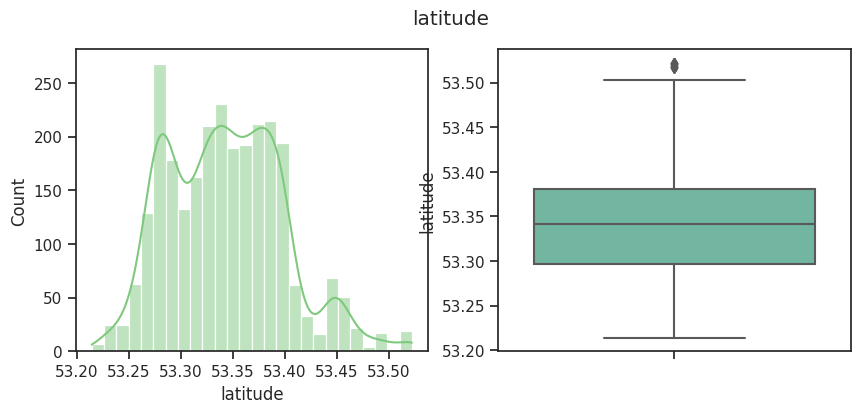

In [ ]:
# plot again without outliers
plot_distribtion(df_train_subset, 'latitude')

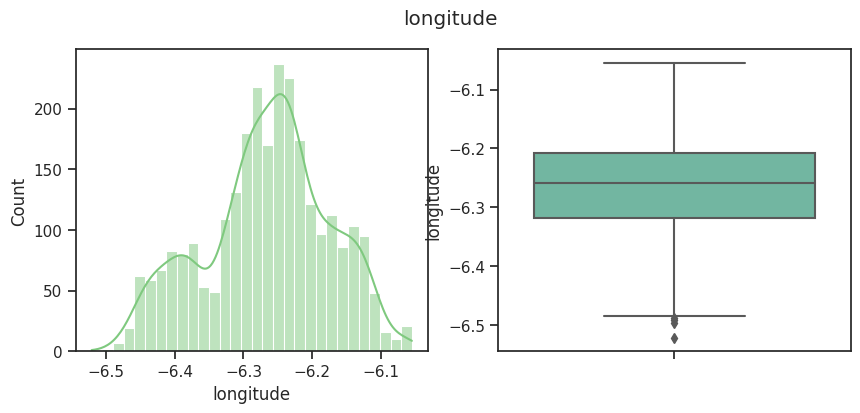

In [ ]:
plot_distribtion(df_train_subset, 'longitude')

In [ ]:
# no null data in the training data. Looks good to plot with.
df_test_subset = df_test[features]
print(f'Columns in df_test_subset: {df_test_subset.columns}')
show_nulls(df_test_subset)

Columns in df_test_subset: Index(['ad_id', 'bathrooms', 'beds', 'latitude', 'longitude', 'surface'], dtype='object')


,Number of Nulls,% of Nulls
ad_id,0,0.0
bathrooms,0,0.0
beds,0,0.0
latitude,0,0.0
longitude,0,0.0
surface,0,0.0


In [ ]:
df_train_subset.head()

,ad_id,bathrooms,beds,latitude,longitude,surface,price
15,9124101,3.0,5.0,53.400454,-6.445730,321.0,935000.0
26,9135354,4.0,4.0,53.316410,-6.385214,144.0,485000.0
27,9135646,3.0,5.0,53.401414,-6.446634,321.0,935000.0
35,9150119,5.0,5.0,53.375377,-6.056749,312.0,1475000.0
38,9150125,2.0,2.0,53.372130,-6.338466,83.0,410000.0


In [ ]:
df_test_subset.head()

,ad_id,bathrooms,beds,latitude,longitude,surface
0,12373510,2.0,4.0,53.566881,-6.101148,142.0
1,12422623,2.0,3.0,53.362992,-6.452909,114.0
2,12377408,3.0,4.0,53.454198,-6.262964,172.0
3,12420093,4.0,3.0,53.354402,-6.458647,132.4
4,12417338,1.0,3.0,53.336530,-6.393587,88.0


<a name="final-data-prep"></a>
### Prep data for modelling

In [ ]:
Xs_train = df_train_subset.iloc[:,1:-1].values 
# train set, output column, cost
ys_train = df_train_subset.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = df_test_subset.iloc[:,1:].values 
# test set, output column, cost
y_test = df_true_price.Expected.values

In [ ]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,(Xs_train[:,[2]]*Xs_train[:,[3]])])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,(Xs_test[:,[2]]*Xs_test[:,[3]])])
Xn_test = xscaler.transform(Xss_test)

# how did we know how to do this?
ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

## Full Model

In [ ]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

Finished [100%]: Average Loss = 2,861.1


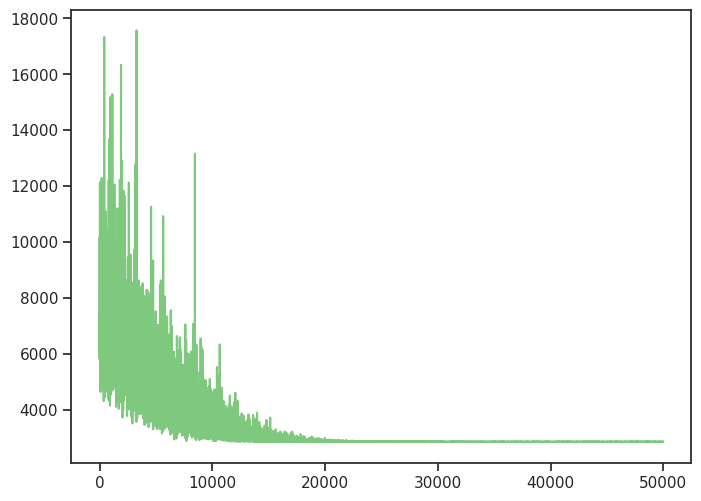

In [ ]:
#number of iterations of the algorithms
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

# samples from the posterior
posterior = approximation.sample(5000)

In [ ]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
full_model_mae = np.mean(abs(y_pred_BLR - y_test))
full_model_mape = np.mean(abs(y_pred_BLR - y_test) / y_test)

print("Full model MAE = ",(full_model_mae))
print("Full model MAPE = ",(full_model_mape))

Full model MAE =  213244.61736415714
Full model MAPE =  0.28461955193324573


# Piecewise Regression

<a name="KMeans"></a>
## Clustering

### KMeans Clustering


In [ ]:
inertia = []
for k in range(1,15):
    clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=20, max_iter=500, random_state=10).fit(Xn_train)
    inertia.append(clustered_data_sklearn.inertia_)

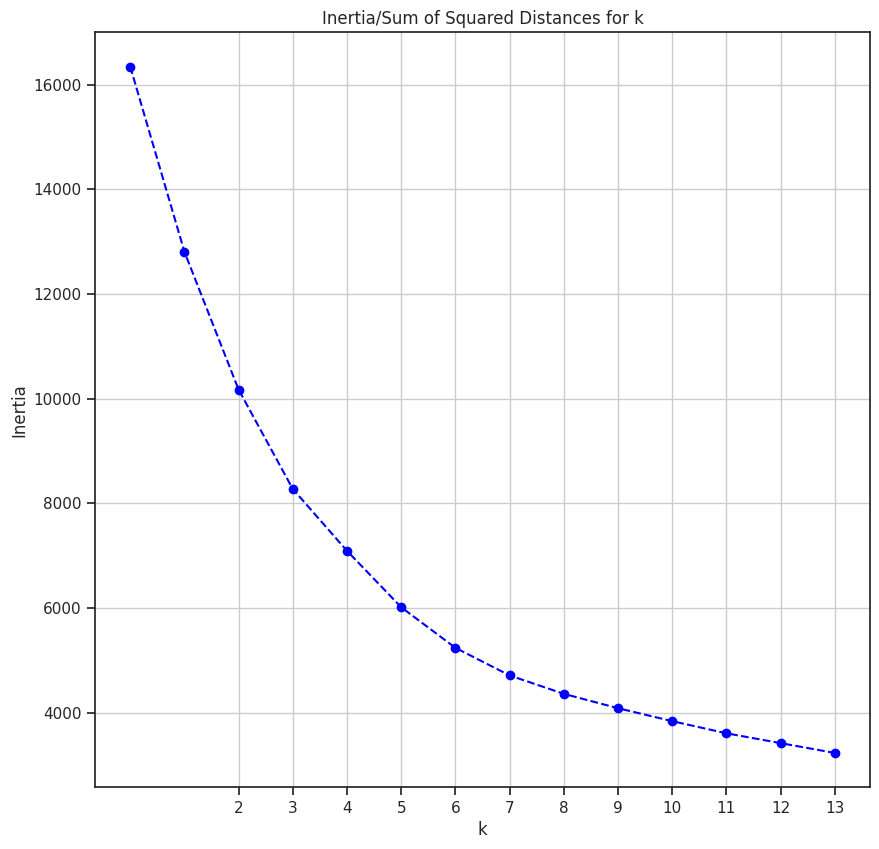

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Inertia/Sum of Squared Distances for k')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.xticks(range(2, 30))
plt.grid()
plt.plot(inertia, linestyle='--', marker='o', color='b')

<a name="silhouette"></a>
### Silhouette metric

In [ ]:
silhouette_coefficients = []
   
# Start at 2 clusters for silhouette coefficient
for k in range(2, 15):
    clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=20, max_iter=500, random_state=10).fit(Xn_train)
    score = silhouette_score(Xn_train, clustered_data_sklearn.labels_)
    silhouette_coefficients.append(score)

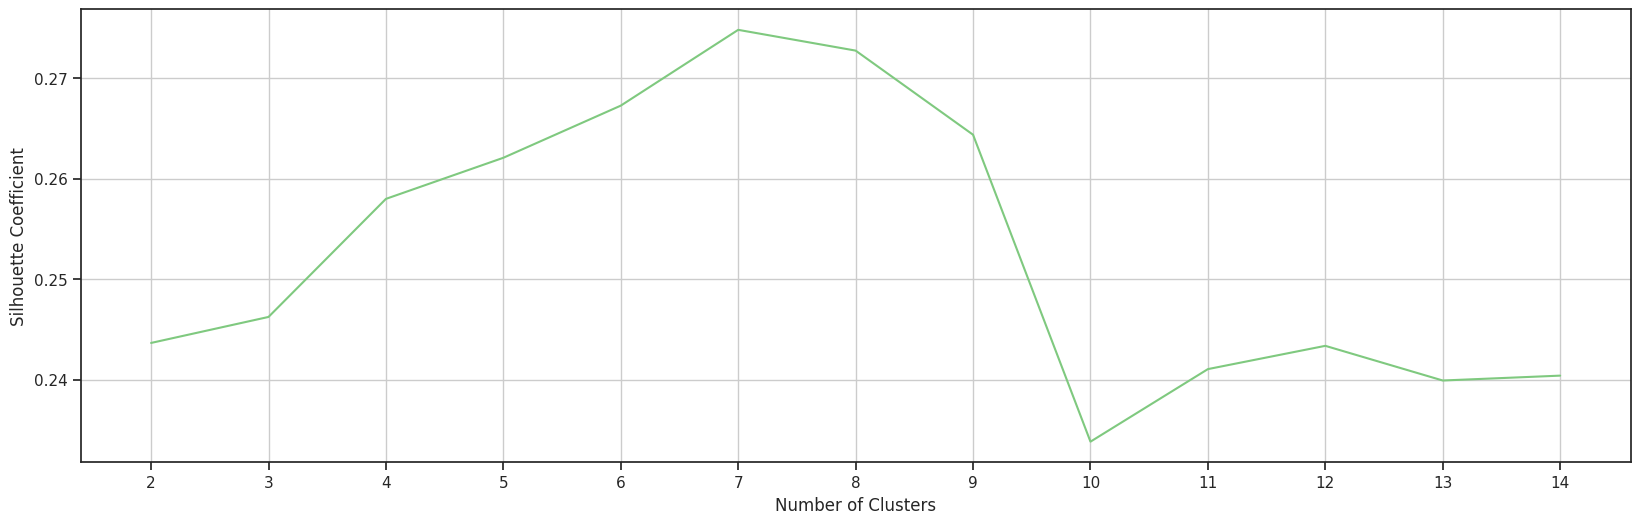

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(range(2,15), silhouette_coefficients)
plt.xticks(range(2, 15))
plt.xticks()
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.grid()
plt.show()

<a name="gmm"></a>
## Agglomerative clustering (Gaussian mixture method)
Choosing the number of components for the GMM model = 7, we can fit the training and test data together using this unsupervised method using the `latitude` and `longitude` features to calculate centres for each breakpoint.



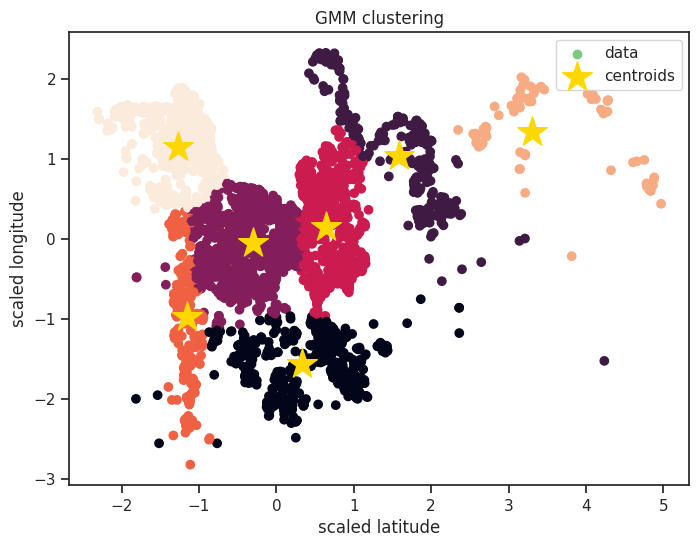

In [653]:
# training gaussian mixture model 


gmm = GaussianMixture(n_components=7)
# clustering by features 2, 3(lat-long)
ind=[2,3]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
labels = gmm.predict(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1], c = labels, label='data')
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1], c='gold', marker='*', s=500, label='centroids')
plt.title('GMM clustering')
plt.ylabel('scaled longitude')
plt.xlabel('scaled latitude')
plt.legend()
plt.show()

### Clusters

In [ ]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))

{0: 590, 1: 38, 2: 387, 3: 394, 4: 261, 5: 215, 6: 839}

In [ ]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 96, 1: 44, 2: 50, 3: 79, 4: 39, 5: 31, 6: 161}

In [ ]:
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_test[clusters_test==0,:]

ylog0 = np.log(ys_train.astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)

In [ ]:
Xn1 = Xn_train[clusters_train==1,:]
Xtestn1 = Xn_test[clusters_test==1,:]
ylog1 = np.log(ys_train.astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)

In [ ]:
Xn2 = Xn_train[clusters_train==2,:]
Xtestn2 = Xn_test[clusters_test==2,:]
ylog2 = np.log(ys_train.astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)

In [ ]:
Xn3 = Xn_train[clusters_train==3,:]
Xtestn3 = Xn_test[clusters_test==3,:]
ylog3 = np.log(ys_train.astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)

In [ ]:
Xn4 = Xn_train[clusters_train==4,:]
Xtestn4 = Xn_test[clusters_test==4,:]
ylog4 = np.log(ys_train.astype('float')[clusters_train==4,:])
yscaler4 = StandardScaler().fit(ylog4)
yn4 = yscaler4.transform(ylog4)

In [ ]:
Xn5 = Xn_train[clusters_train==5,:]
Xtestn5 = Xn_test[clusters_test==5,:]
ylog5 = np.log(ys_train.astype('float')[clusters_train==5,:])
yscaler5 = StandardScaler().fit(ylog5)
yn5 = yscaler5.transform(ylog5)

In [ ]:
Xn6 = Xn_train[clusters_train==6,:]
Xtestn6 = Xn_test[clusters_test==6,:]
ylog6 = np.log(ys_train.astype('float')[clusters_train==6,:])
yscaler6 = StandardScaler().fit(ylog6)
yn6 = yscaler6.transform(ylog6)

In [ ]:
print(yscaler0.scale_)
print(yscaler1.scale_)
print(yscaler2.scale_)
print(yscaler3.scale_)
print(yscaler4.scale_)
print(yscaler5.scale_)
print(yscaler6.scale_)

[0.46015047]
[0.42207228]
[0.4864882]
[0.6732387]
[0.62648364]
[0.39975566]
[0.59620284]


## Piecewise Model

In [ ]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(5000)

Finished [100%]: Average Loss = 612.06


In [ ]:
# model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])

with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior1 = approximation.sample(5000)

Finished [100%]: Average Loss = 81.772


In [ ]:
# model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 2d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])

with model_2:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior2 = approximation.sample(5000)

Finished [100%]: Average Loss = 468.68


In [ ]:
# model_3
with pm.Model() as model_3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn3.T)
  # likelihood, be sure that observed is a 3d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])

with model_3:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior3 = approximation.sample(5000)

Finished [100%]: Average Loss = 474.39


In [ ]:
# model_4
with pm.Model() as model_4:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn4.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn4.T)
  # likelihood, be sure that observed is a 4d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn4[:,0])

with model_4:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior4 = approximation.sample(5000)

Finished [100%]: Average Loss = 246.43


In [ ]:
# model_5
with pm.Model() as model_5:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn5.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn5.T)
  # likelihood, be sure that observed is a 5d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn5[:,0])

with model_5:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior5 = approximation.sample(5000)

Finished [100%]: Average Loss = 222.55


In [ ]:
# model_6
with pm.Model() as model_6:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn6.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn6.T)
  # likelihood, be sure that observed is a 5d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn6[:,0])

with model_6:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior6 = approximation.sample(5000)

Finished [100%]: Average Loss = 817.96


##Simulations

In [ ]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred

### Only Cluster 0

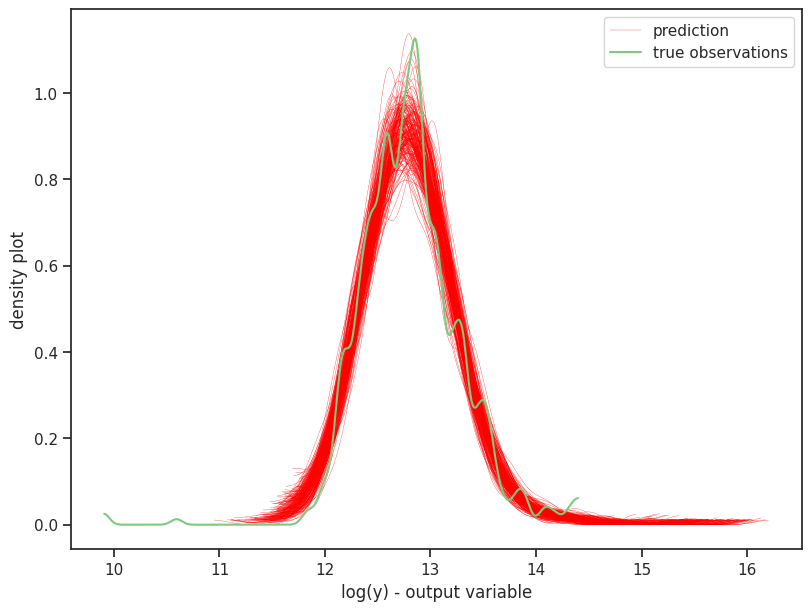

In [ ]:
#Simulation
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

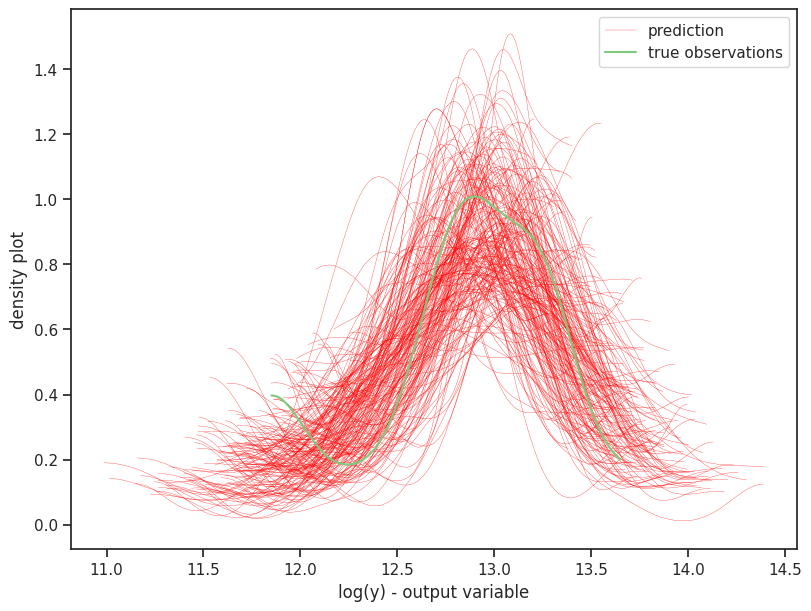

In [ ]:
#Simulation
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
for i in range(Ypred1.shape[0]):
    az.plot_dist( Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
az.plot_dist(ylog1,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

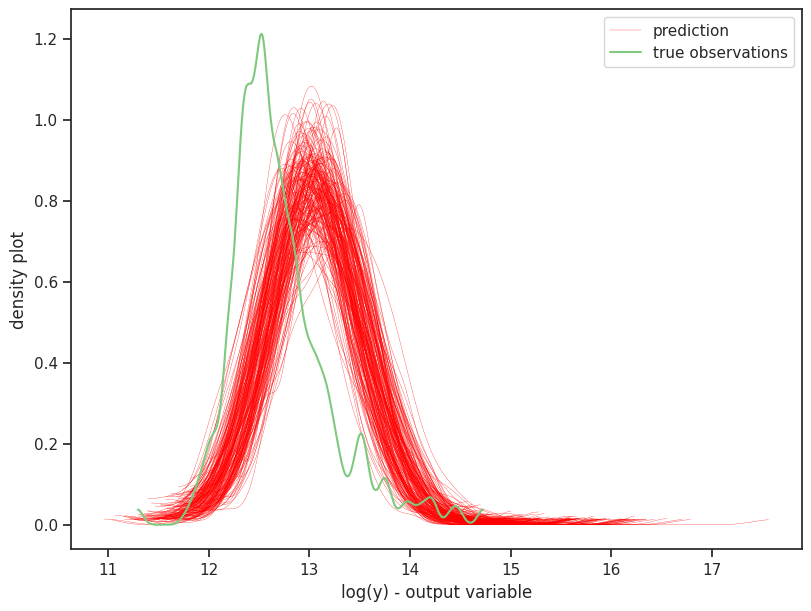

In [ ]:
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior1['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
for i in range(Ypred2.shape[0]):
    az.plot_dist( Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
az.plot_dist(ylog2,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

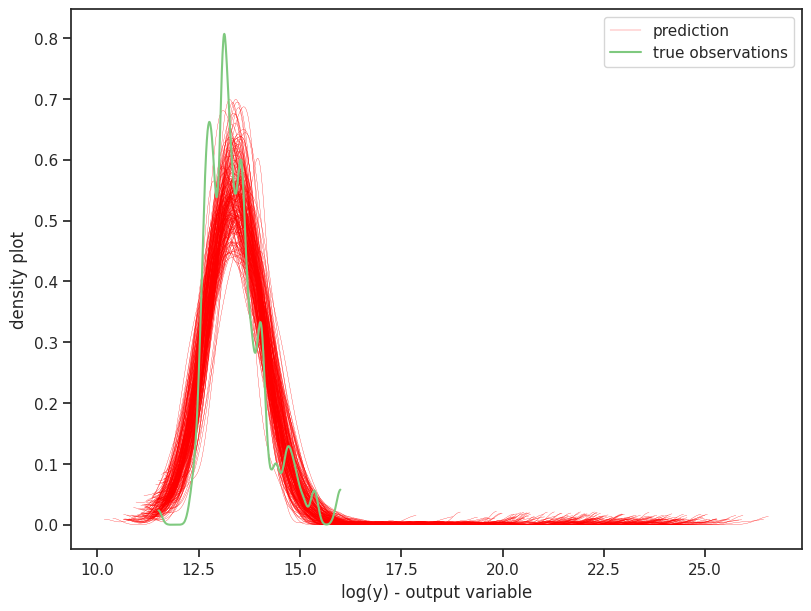

In [ ]:
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior1['beta'],posterior3['sigma_n'],Xn3,  nsamples=200))
for i in range(Ypred3.shape[0]):
    az.plot_dist( Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
az.plot_dist(ylog3,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

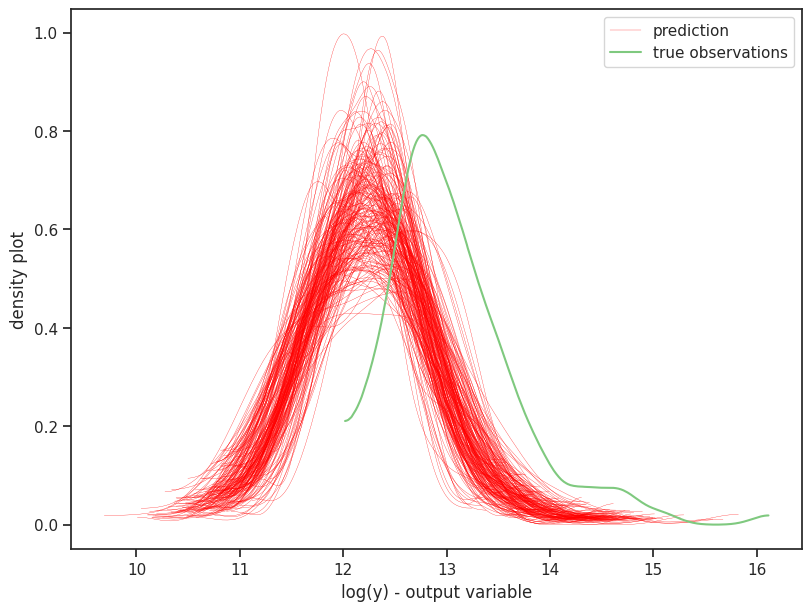

In [ ]:
Ypred4 = yscaler4.inverse_transform(ppc(posterior4['alpha'],posterior1['beta'],posterior4['sigma_n'],Xn4,  nsamples=200))
for i in range(Ypred4.shape[0]):
    az.plot_dist( Ypred4[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred4[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
az.plot_dist(ylog4,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

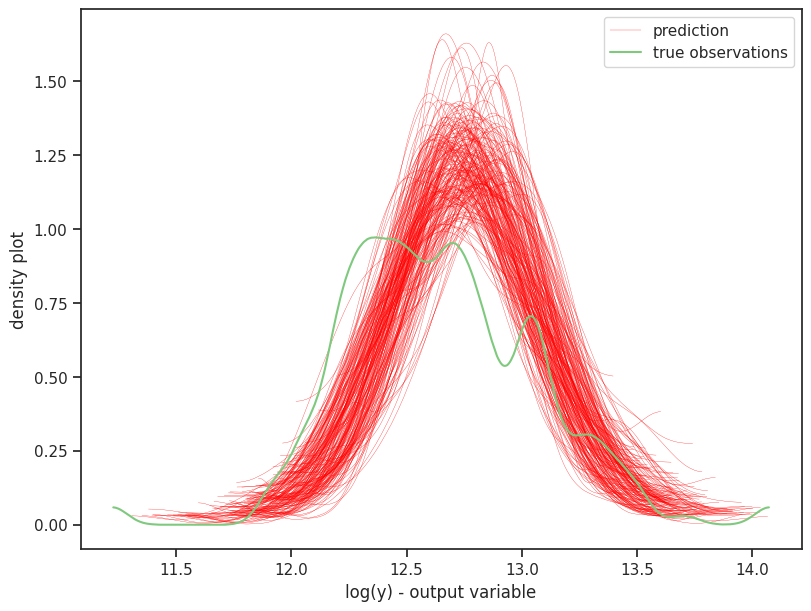

In [ ]:
Ypred5 = yscaler5.inverse_transform(ppc(posterior5['alpha'],posterior1['beta'],posterior5['sigma_n'],Xn5,  nsamples=200))
for i in range(Ypred5.shape[0]):
    az.plot_dist( Ypred5[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred5[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
az.plot_dist(ylog5,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

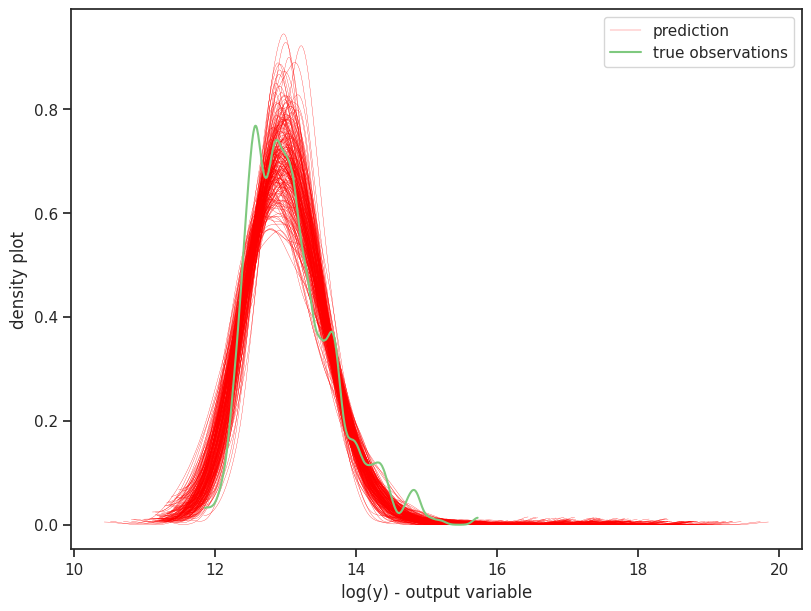

In [ ]:
Ypred6 = yscaler6.inverse_transform(ppc(posterior6['alpha'],posterior1['beta'],posterior6['sigma_n'],Xn6,  nsamples=200))
for i in range(Ypred6.shape[0]):
    az.plot_dist( Ypred6[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred6[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
az.plot_dist(ylog6,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Overall

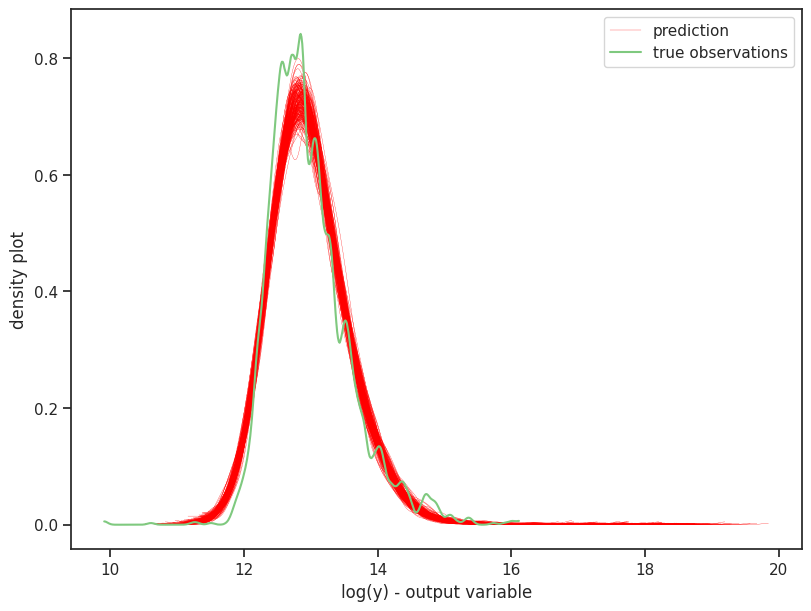

In [ ]:
# posteriors
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200)
Ypred4 = ppc(posterior4['alpha'],posterior4['beta'],posterior4['sigma_n'],Xn4,  nsamples=200)
Ypred5 = ppc(posterior5['alpha'],posterior5['beta'],posterior5['sigma_n'],Xn5,  nsamples=200)
Ypred6 = ppc(posterior6['alpha'],posterior6['beta'],posterior6['sigma_n'],Xn6,  nsamples=200)

# simulation
Ypred = np.hstack([ yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3),
                 yscaler4.inverse_transform(Ypred4),
                 yscaler5.inverse_transform(Ypred5),
                 yscaler6.inverse_transform(Ypred6)])

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([ylog0,ylog1,ylog2,ylog3, ylog4, ylog5, ylog6])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Test set performance

In [ ]:
# cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))
print("Size Cluster0", np.sum(clusters_test==0), ", MAE Cluster0=",
      (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]))))

# cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) 
              + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))
print("Size Cluster1", np.sum(clusters_test==1), ", MAE Cluster1=",
      (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]))))

# cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) 
              + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))
print("Size Cluster2", np.sum(clusters_test==2), ", MAE Cluster2=",
      (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]))))

# cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) 
              + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))
print("Size Cluster3", np.sum(clusters_test==3), ", MAE Cluster3=",
      (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]))))


y_pred_BLR4 = np.exp(yscaler4.inverse_transform(np.mean(posterior4['alpha']) 
              + np.dot(np.mean(posterior4['beta'],axis=0), Xtestn4.T)))
print("Size Cluster4", np.sum(clusters_test==4), ", MAE Cluster4=",
      (np.mean(abs(y_pred_BLR4 - y_test[clusters_test==4]))))


y_pred_BLR5 = np.exp(yscaler5.inverse_transform(np.mean(posterior5['alpha']) 
              + np.dot(np.mean(posterior5['beta'],axis=0), Xtestn5.T)))
print("Size Cluster5", np.sum(clusters_test==5), ", MAE Cluster5=",
      (np.mean(abs(y_pred_BLR5 - y_test[clusters_test==5]))))

y_pred_BLR6 = np.exp(yscaler6.inverse_transform(np.mean(posterior6['alpha']) 
              + np.dot(np.mean(posterior6['beta'],axis=0), Xtestn6.T)))
print("Size Cluster6", np.sum(clusters_test==6), ", MAE Cluster6=",
      (np.mean(abs(y_pred_BLR6 - y_test[clusters_test==6])), "MAPE Cluster6=", np.mean(abs(y_pred_BLR6 - y_test[clusters_test==6]) / y_test[clusters_test==6])))

# joint
joint=np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test[clusters_test==3]),
                 abs(y_pred_BLR4 - y_test[clusters_test==4]),
                 abs(y_pred_BLR5 - y_test[clusters_test==5]),
                 abs(y_pred_BLR6 - y_test[clusters_test==6])])

joint_mape =np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]) / y_test[clusters_test==0],
                 abs(y_pred_BLR1 - y_test[clusters_test==1]) / y_test[clusters_test==1],
                 abs(y_pred_BLR2 - y_test[clusters_test==2]) / y_test[clusters_test==2],
                 abs(y_pred_BLR3 - y_test[clusters_test==3]) / y_test[clusters_test==3],
                 abs(y_pred_BLR4 - y_test[clusters_test==4]) / y_test[clusters_test==4],
                 abs(y_pred_BLR5 - y_test[clusters_test==5]) / y_test[clusters_test==5],
                 abs(y_pred_BLR6 - y_test[clusters_test==6]) / y_test[clusters_test==6]])

# MAE
print("MAE=",np.mean(joint))
print("MAPE=",np.mean(joint_mape))

Size Cluster0 96 , MAE Cluster0= 127312.75593176002
Size Cluster1 44 , MAE Cluster1= 111911.49436333906
Size Cluster2 50 , MAE Cluster2= 124023.05734899691
Size Cluster3 79 , MAE Cluster3= 271052.9838112508
Size Cluster4 39 , MAE Cluster4= 187190.03371128158
Size Cluster5 31 , MAE Cluster5= 55441.43112479669
Size Cluster6 161 , MAE Cluster6= (265747.5446167528, 'MAPE Cluster6=', 0.24365760148434254)
MAE= 193129.83854576084
MAPE= 0.2582104727758996


### PPC on the Test set



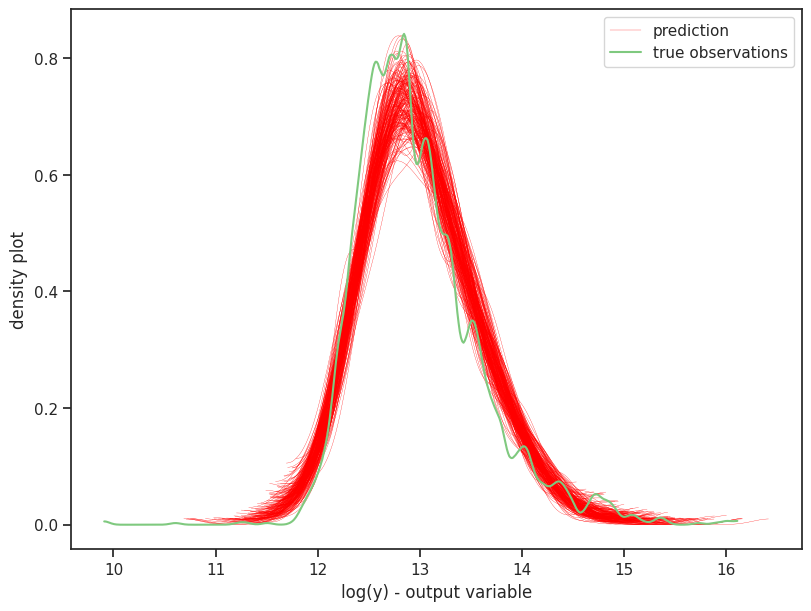

In [ ]:
# posteriors
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3,  nsamples=200)
Ypred4 = ppc(posterior4['alpha'],posterior4['beta'],posterior4['sigma_n'],Xtestn4,  nsamples=200)
Ypred5 = ppc(posterior5['alpha'],posterior5['beta'],posterior5['sigma_n'],Xtestn5,  nsamples=200)
Ypred6 = ppc(posterior6['alpha'],posterior6['beta'],posterior6['sigma_n'],Xtestn6,  nsamples=200)

# simulation
Ypred = np.hstack([ yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3),
                 yscaler4.inverse_transform(Ypred4),
                 yscaler5.inverse_transform(Ypred5),
                 yscaler6.inverse_transform(Ypred6)])

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([ylog0,ylog1,ylog2,ylog3, ylog4, ylog5, ylog6])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

# Summary


---



## E-tivity summary

This e-tivity provided an interesting foray into piecewise probabilistic linear regression to solve complex datasets with a simple and explainable model. Further more this approach coupled very well with a selection of [SKlearn's clustering methods](https://scikit-learn.org/stable/modules/clustering.html) (namely Gaussian mixture models, KMeans clustering models and one of the library's evaluation metrics called the Silhouette coefficient. Using these 3 clustering methods provided a nuanced approach to locate the number and locations of the breakpoints in our multidimensional feature space. I found this approach very interesting that leveraging these clustering methods enabled us to keep the complexity of our model low and enhance our performance.


 <br/><br/>

---

### Conclusions & Results
The full probabilistic regression model was outperformed by the piecewise probabilitistic regression model using the mean absolute error (MAE) and mean absolute percentage error (MAPE) as evaluation criterion.

|      | Full model | Piecewise model |
|------|------------|-----------------|
| MAE  | 213,244    | 193,129         |
| MAPE | 0.284      | 0.258           |

There appears to be about a 2.5% improvement in the model performance using the Piecewise Bayesian linear regression model.

There was a nice link between this model and previous models on data analytics where we had covered transformations of variables to a normal distribution, heatmaps, boxplots, imputing values and other data preparation techniques to enhance the training dataset. In fact I found this was the key to the problem, in order to not have a cluster on an outlier which would have wasted a centroid at the cost of a dimension.
 
 <br/><br/>

---


### Pros-cons of dataset, techniques and methods
The dataset was large and had many features. The training dataset after preparation consisted of almost 2750 samples with a test set of 500 samples. 

From explorations of the dataset, we were able to remove outliers in the variables we decided to keep, impute missing values for data that was missing for some features and create feature crosses in order to provide more features for the model to train on. Exploring the dataset was a task that I iterated upon, which is a very realistic approach. I went from just dropping all rows with `NaNs` and adding no new features to see the performance on the model on test data with a basic training set, to enhancing the dataset which had a positive effect on reducing `MAPE Mean absolute percentage error` and `MAE (Mean absolute error)`. The final approach to my dataset preparation can be found in the [dataset prep section of the notebook](#dataset).

A more in depth analysis of clustering methods was required to use piecewise regression with was an initial obstacle. KMeans clustering with the inertia metric [failed to provide a clear value](#KMeans) for K the number of breakpoints to use in our piecewise model. Using the silhouette metric with KMeans [showed a clear peak of K = 7](#silhouette). Then [fitting the GMM model](#gmm) we were able to assign every datapoint to a class and hence a piecewise model that would be used to predict their target variable. While this method seems to show good results in this version of the notebook, I found I had to revisit the data preparation approach to obtain clear separation as I found the GMM was very susceptible to being thrown off by the appearance of outliers. Once removing these [outliers](#outliers) the GMM plot proved to be more insightful.

While the full model for the whole dataset did not provide as low a mean absolute it provided reasonable results for much less coding and computational work (there was no clustering or multiple models required). However the pay off with the piecewise regression model was apparent with it's lower `MAPE` results on the dataset. On further reflection I find the piecewise regression approach particularly intuitive for problems like this where the feature space (in this case the landscape of Dublin and the features of its houses) vary in price in different areas of the city. By training different models for different breakpoints enables the models to fit subleties in the areas easier (without overfitting as the Bayesian models come with uncertainties in their probability distributions.

### Peer discussion

On the forums I had some good discussions with Robert Barrett and James Gibbons. I was unsure whether of not the GMM model should be trained on the test data as well. James showed that training it with and without the test data didn't affect the `MAPE` value significantly in the end. However James

# References


In [ ]:

#Export PDF file of the notebook to Google drive
%%capture
pdf_path = '/content/drive/My Drive/Masters/ET5003_Enrique/etivity2/pdf/'
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('ET5003_Etivity2_CONOROMARA_20151845.ipynb')

SyntaxError: ignored